In [1]:
using Gen, Plots, LinearAlgebra

In [2]:
num_points = 50;
slope = 0.3;
intercept = 1.;

slope1 = 0.3;
slope2 = -0.7;
intercept1 = 1.;
changepoint = -1.;
intercept2 = slope1*changepoint+intercept1


0.7

In [3]:
xs_dense = collect(range(-5, stop=5, length=num_points))
xs_noise = xs_dense - randn(length(xs_dense))*0.1
# ys_simple = fill(1., length(xs_dense)) .+ randn(length(xs_dense)) * 0.1
ys_simple = xs_noise*slope .+ intercept + randn(num_points)*0.1
# ys_complex = [Int(floor(abs(x/3))) % 2 == 0 ? 2 : 0 for x in xs_dense] .+ randn(length(xs_dense)) * 0.1;
function line(x, m, b)
    return m*x + b
end
ys_complex = [x<changepoint ? line(x-randn()*0.1,slope1,intercept1) : line(x-randn()*0.1,slope2,intercept2) for x in xs_dense] .+ randn(length(xs_dense)) * 0.1;


In [4]:
print(ys_complex)

[-0.5104713511140402, -0.2540007585663998, -0.40561991417646337, -0.32334257877849665, -0.16345902843531435, -0.07357120138082855, -0.09458507763168161, 0.08654943226886189, 0.0465723813961944, -0.35637141929553984, 0.17962442956786842, 0.0953464590509234, 0.27681019037536, 0.41057465777817337, 0.384824006331218, 0.39817554317862885, 0.4354352271998088, 0.6386354925390473, 0.5569218635476131, 0.4363878573852472, 1.3526592292881068, 1.304337974483008, 1.0469040168724246, 1.0909389703662544, 0.8224279071677592, 0.89230843331087, 0.4942687548536082, 0.4314644200635173, -0.0005727480885341363, -0.17429883265972787, -0.3260806234207879, -0.34994712732812916, -0.5314907264307382, -0.4923569371382554, -0.5576810616963253, -0.8042790087921832, -0.7298027276111059, -1.0980960020226949, -1.2470609289402597, -1.2880453761026476, -1.4784632917759828, -1.486335232479665, -1.9783591114254508, -1.9832227698004123, -2.059264594350577, -2.1775186440251653, -2.1886025694891713, -2.479403170151005, -2.84

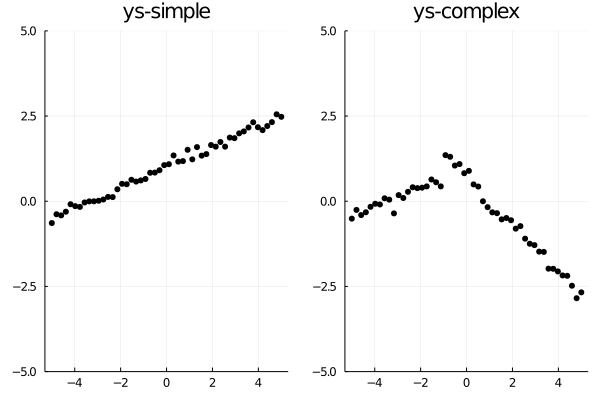

In [5]:
simple_plot = scatter(xs_dense, ys_simple, color="black", label=nothing, title="ys-simple", ylim=(-5, 5))
complex_plot = scatter(xs_dense, ys_complex, color="black", label=nothing, title="ys-complex", ylim=(-5, 5))
Plots.plot(simple_plot, complex_plot)

In [6]:
struct Interval
    l::Float64
    u::Float64
end

abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    slope::Float64
    interval::Interval
end

In [7]:
# @gen function generate_segments(l::Float64, u::Float64, s::Float64=0.0, init::Bool=true)
#     if init==true
#         s = ({:s} ~ normal(0,1))
#     end
#     interval = Interval(l, u)
#     if ({:isleaf} ~ bernoulli(0.7))
#         angle = ({:angle} ~ uniform(0,2*pi))
#         slope = atan(angle)
#         return LeafNode(s, slope, interval)
#     else
#         frac = ({:frac} ~ beta(2, 2))
#         mid  = l + (u - l) * frac
#         left = ({:left} ~ generate_segments(l, mid, s, init=false))
#         right = ({:right} ~ generate_segments(mid, u, s, init=false))
#         return InternalNode(left, right, interval)
#     end
# end;

In [8]:
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    if ({:isleaf} ~ bernoulli(0.9))
        value = ({:value} ~ normal(0,1))
        angle = ({:angle} ~ uniform(-pi/2,pi/2))
        slope = tan(angle)
        # slope = ({:slope} ~ normal(0,2))
        return LeafNode(value, slope, interval)
    else
        frac = ({:frac} ~ beta(2, 2))
        mid  = l + (u - l) * frac
        left = ({:left} ~ generate_segments(l, mid))
        right = ({:right} ~ generate_segments(mid, u))
        return InternalNode(left, right, interval)
    end
end;

In [9]:
function render_node!(node::LeafNode)
    plot!([node.interval.l, node.interval.u], [node.value, node.value+node.slope*(node.interval.u-node.interval.l)], label=nothing, linewidth=5)
end

function render_node!(node::InternalNode)
    render_node!(node.left)
    render_node!(node.right)
end;
function render_segments_trace(trace; xlim=(0,1))
    node = get_retval(trace)
    fig = plot(xlim=xlim, ylim=(-3, 3))
    render_node!(node)
    return fig
end;
function gridded(renderer::Function, traces)
    Plots.plot(map(renderer, traces)...)
end;
function do_inference(model, xs, ys, amount_of_computation)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

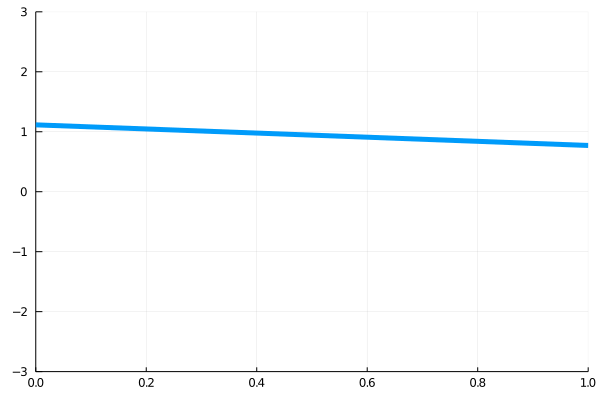

In [10]:
trace = Gen.simulate(generate_segments, (0., 1.))
render_segments_trace(trace)

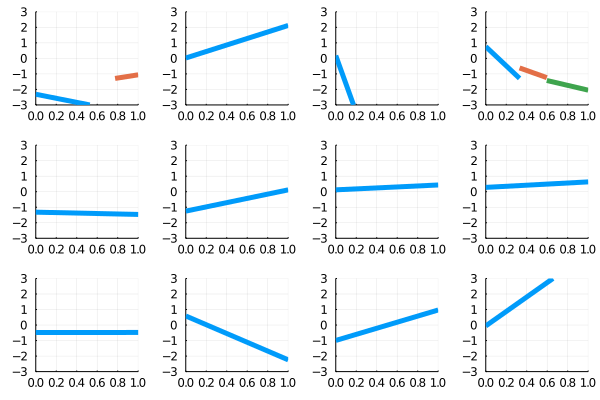

In [11]:
traces = [Gen.simulate(generate_segments, (0., 1.)) for i=1:12]
gridded(render_segments_trace, traces)

In [12]:
# get_value_at searches a binary tree for
# the leaf node containing some value.
function get_value_at(x::Float64, node::LeafNode)
    @assert x >= node.interval.l && x <= node.interval.u
    return node.value*node.slope*(x-node.interval.l)
end

function get_value_at(x::Float64, node::InternalNode)
    @assert x >= node.interval.l && x <= node.interval.u
    if x <= node.left.interval.u
        get_value_at(x, node.left)
    else
        get_value_at(x, node.right)
    end
end

# Our full model
@gen function changepoint_model(xs::Vector{Float64})
    node = ({:tree} ~ generate_segments(minimum(xs), maximum(xs)))
    noise = ({:noise} ~ gamma(0.5, 0.5))
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(get_value_at(x, node), noise)
    end
    return node
end;

In [13]:
function render_changepoint_model_trace(trace; show_data=true)
    xs = Gen.get_args(trace)[1]
    node = Gen.get_retval(trace)
    fig = render_segments_trace(trace; xlim=(minimum(xs), maximum(xs)))
    render_node!(node)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        scatter!(xs, ys, c="gray", label=nothing, alpha=0.3, markersize=3)
    end
end;

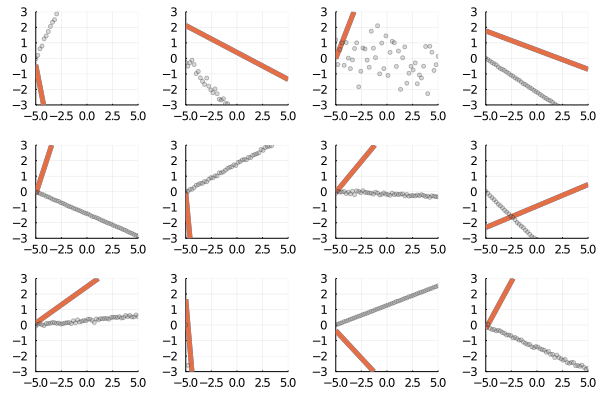

In [14]:
traces = [Gen.simulate(changepoint_model, (xs_dense,)) for i=1:12]
gridded(render_changepoint_model_trace, traces)

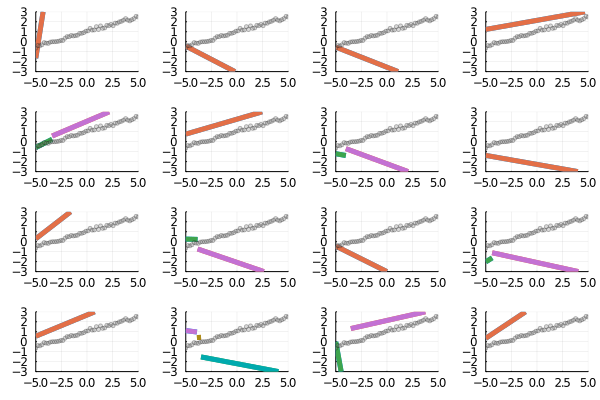

In [15]:
traces = [do_inference(changepoint_model, xs_dense, ys_simple, c) for c=0:2000:30000];
gridded(render_changepoint_model_trace, traces)

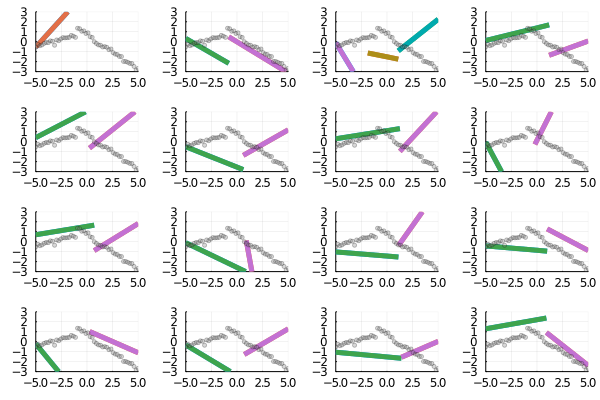

In [16]:
traces = [do_inference(changepoint_model, xs_dense, ys_complex, c) for c=0:2000:30000];
gridded(render_changepoint_model_trace, traces)